In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.stats import mad_std
import astropy.units as u
from convenience_functions import show_image

# suppress warnings is not recommended :I
import warnings
warnings.filterwarnings("ignore")

bias_dir = './data/bias'
flat_dir = './data/flat'
darks_dir = './data/dark'
tzboo_dir = './data/tz_boo'
cccom_dir = './data/cc_com'

# Responses to the Data Reduction & Photometry Lab
## 1. Define the bias. Include both a description of what it looks like physically, why it occurs, and how we take it into account (how do we remove its effect on our data images?)

A bias contains a grid of values added to every pixel on the CCD to ensure no negative pixel values are output. A bias value to a pixel can be likened to adjusting the y-intercept of a linear function. We expect to account for negative pixel counts because reading noise can be modeled as a Gaussian distribution with a mean of zero and some standard deviation. The read noise comes from material imperfections of the CCD. Ideally, a bias would be uniform across all CCD pixels.

In practice, biases are offset voltages. To take a bias of a given CCD instrument, one reads out the CCD with zero exposure time. 

## 2. Why would we use more than one bias frame?

The noise reduction factor goes like $\sim 1/\sqrt{N}$, with $N$ as the number of combined biases to be combined. Having multiple biases thus increases the amount the noise is reduced

## 3. List the average value of each of your bias frames, as well as your final master bias.

In [ ]:
biases = ImageFileCollection(bias_dir).files_filtered(imagetyp='bias', include_path=True)

combined_bias = ccdp.combine(biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6,
                             unit='adu'
                            );
combined_bias.write(bias_dir + '/combined_bias.fits')

In [26]:
reduced_biases = ImageFileCollection(bias_dir).files_filtered(imagetyp='bias', include_path=True)
for bias in reduced_biases:
    mean = CCDData.read(bias, unit='adu').data.mean()
    print(f'mean for {bias}: {mean:.3f}')
    
    
combined_bias = CCDData.read(bias_dir + '/combined_bias.fits')
print('combined mean: ' + str(combined_bias.data.mean()))

mean for ./data/bias/Bias_BIN1_20230424_031732.fits: 980.423
mean for ./data/bias/Bias_BIN1_20230424_031823.fits: 980.209
mean for ./data/bias/Bias_BIN1_20230424_031904.fits: 980.381
mean for ./data/bias/Bias_BIN1_20230424_031946.fits: 980.619
mean for ./data/bias/Bias_BIN1_20230424_032028.fits: 980.514
mean for ./data/bias/Bias_BIN1_20230424_032109.fits: 980.559
mean for ./data/bias/Bias_BIN1_20230424_032152.fits: 980.830


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
mean for ./data/bias/combined_bias.fits: 980.505
combined mean: 980.5052719468449


## 4. Define “overscan”

An overscan is the covered portion of the CCD sensor. This feature is useful in removing variations in the bias on a frame-by-frame basis. Data from the overscan includes bias, read noise, and dark current.

## 5. List your overscan parameters. (Where is the overscan on your images?)

ARCSAT images have no overscan.

## 6. Which filters do you have flat fields for? List the flat field file names for each filter that you need. Do you have more flats than you need? Confirm that your flat fields have the same binning as your data.

Our project took flat fields for B and V filters. Both observation images and flats have 1x1 binning. The files include:

In [ ]:
flats = ImageFileCollection(flat_dir)
flats.summary['file', 'xbinning', 'ybinning']

In [ ]:
tz_boo = ImageFileCollection(tzboo_dir)
tz_boo.summary['file', 'xbinning', 'ybinning']

In [ ]:
cc_com = ImageFileCollection(cccom_dir)
cc_com.summary['file', 'xbinning', 'ybinning']

## 7. Why do we need flat fields for each filter we have used for observations?
Flats involve reading data taken from a controlled source of light. They are taken to correct for visual artifacts like vignetting, dust on the CCD, etc. We need to make flat fields for each filter as the CCD sensor's response depends on the wavelength of incident photons.

- BIAS SUBTRACTION AND FLAT FIELD NORMALIZATION SHOULD BE DONE ON EACH OF
YOUR OBJECT IMAGE FILES. It is a good place to take a little time and develop a loop, or a
small pseudo pipeline

- To do: flat field normalization

## 8. What drawbacks could exist from this method of sky subtraction?
Determining the cutoff brightness for what pixel is considered a part of a star's light or the sky background brightness is not well-defined. If the cutoff brightness for the sky is too high, one might not account for all the light coming from a star. In the opposite case, too low of a cutoff brightness may overestimate the light coming from a star.

## 9. Why does sky subtraction matter?
Sky subtraction matters because the contributions of light from the background sky can add to the counts of a star one intends to measure. Not accounting for the contributions due to the background sky can cause overestimations in the brightness of a star.

## 10. How many objects did you identify with DAOStarFinder? Look at your image. Do you think that’s a reasonable number? What did you change to adjust the number of stars detected? How many stars did you end up with?

I found 109 stars from using the example parameters for DAOStarFinder, with the parameters being:

- FWHM = 3.0
- stdev $(\sigma)$ = 3.0
- threshold = $5\sigma$

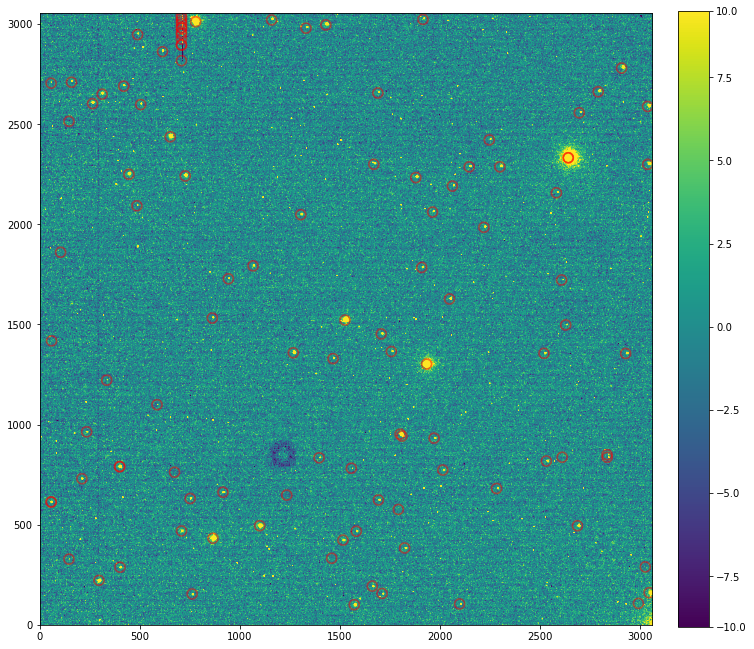

In [13]:
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder

tzboo3 = CCDData.read('./data/tz_boo/reduced/REDUCED_TZ_Boo_15s_V_3_20230505_053321.fits')

mean, median, std = sigma_clipped_stats(tzboo3.data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(tzboo3.data)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
# plt.imshow(tzboo3.data, cmap='Greys', origin='lower', norm=norm,
#            interpolation='nearest');

fig, ax = plt.subplots(figsize=(12, 12))

show_image(tzboo3.data, fig=fig, ax=ax)
apertures.plot(color='red', lw=10, alpha=0.5);


In [14]:
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)
sources.write('./results/ap-tzboo_335.csv', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------ -----
  1   1570.53    100.32      0.52      -0.26 ... 0.00  1171.00  13.17 -2.80
  2   2096.68    104.21      0.71       0.25 ... 0.00   102.11   1.00 -0.00
  3   2989.59    106.84      0.55      -0.44 ... 0.00    41.01   1.01 -0.01
  4    761.16    154.00      0.56       0.22 ... 0.00   117.87   1.21 -0.20
  5   1709.73    156.34      0.48      -0.13 ... 0.00   165.47   1.98 -0.74
  6   3043.05    160.22      0.50      -0.16 ... 0.00  3818.96  45.25 -4.14
  7   1660.60    193.30      0.48       0.35 ... 0.00   172.43   2.12 -0.82
...       ...       ...       ...        ... ...  ...      ...    ...   ...
103    708.17   3001.27      0.87      -0.21 ... 0.00   152.43   2.56 -1.02
104    778.95   3011.26      0.43      -0.50 ... 0.00 13075.42 123.73 -5.23
105    708.06   3013.40      0.24      -0.13 ... 0.00    44.17   2.83 -1.13
106   1158.2

## (Continued)
After adjusting the parameters to become:

- FWHM = 4.0
- stdev $(\sigma)$ = 4.0
- threshold = $6\sigma$

...The number of entries decreases from 109 to 93.

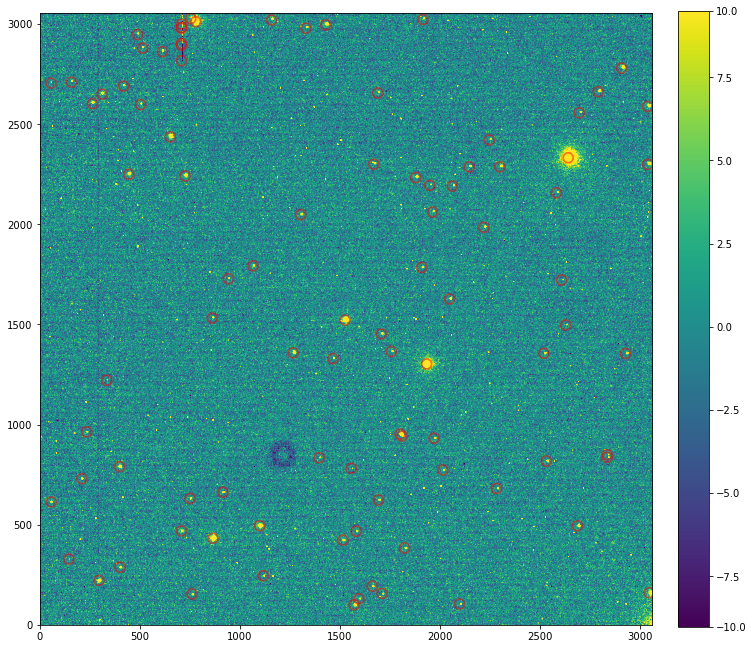

In [8]:
tzboo3 = CCDData.read('./data/tz_boo/reduced/REDUCED_TZ_Boo_15s_V_3_20230505_053321.fits')

mean, median, std = sigma_clipped_stats(tzboo3.data, sigma=4.0)
daofind = DAOStarFinder(fwhm=4.0, threshold=6.*std)
sources = daofind(tzboo3.data)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())

fig, ax = plt.subplots(figsize=(12, 12))

show_image(tzboo3.data, fig=fig, ax=ax)
apertures.plot(color='red', lw=10, alpha=0.5);

In [11]:
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)

sources.write('./results/ap-tzboo_446.csv', overwrite=True)

## 11. Are you happy with your apertures? Why or why not? Save the list of sources for comparison.

- **CC Com**
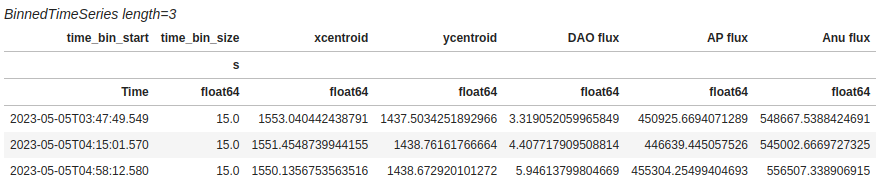

- **TZ Boo**
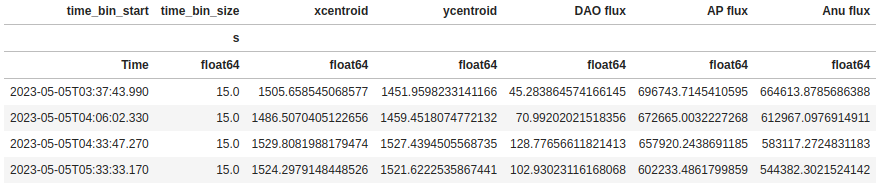

## 12. Using PSF

In [22]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import IRAFStarFinder
from photutils.psf import (DAOGroup, IntegratedGaussianPRF,
                           IterativelySubtractedPSFPhotometry)

from astropy.timeseries import BinnedTimeSeries, TimeSeries
from astropy.table import Table

In [18]:
tzboo_info = BinnedTimeSeries.read(
    './results/tzboo_DAOresults.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

In [21]:
tzboo_info[3]['xcentroid']

1524.2979148448526

In [27]:
[[tzboo_info[3]['xcentroid']], [tzboo_info[3]['ycentroid']]]

[[1524.2979148448526], [1521.6222535867441]]

In [28]:
centroid = Table(
    names=['x_0', 'y_0'],
    data=[[tzboo_info[3]['xcentroid']], [tzboo_info[3]['ycentroid']]]
)
centroid

x_0,y_0
float64,float64
1524.2979148448526,1521.6222535867441


In [29]:
image = CCDData.read('./data/tz_boo/reduced/REDUCED_TZ_Boo_15s_V_3_20230505_053321.fits')

tzboo_info = BinnedTimeSeries.read(
    './results/tzboo_DAOresults.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
centroid = Table(
    names=['x_0', 'y_0'],
    data=[[tzboo_info[3]['xcentroid']], [tzboo_info[3]['ycentroid']]]
)

sigma_psf = 2.0

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf * gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11, 11))
result_tab2 = photometry(image=image, init_guesses=centroid)
residual_image2 = photometry.get_residual_image()

In [30]:
result_tab2

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64
1524.2979148448526,1521.6222535867441,134554.14122932917,1,1,1524.2556720644282,1521.6084735199697,166940.4355070842,4349.776999156999,0.07454399252990962,0.07453413570044508,1
